In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
syp500 = yf.download("^GSPC", start="2000-01-01")

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Observamos si hay valores faltantes
syp500.count()

Open         5826
High         5826
Low          5826
Close        5826
Adj Close    5826
Volume       5826
dtype: int64

In [ ]:
#Separamos los datos del ultimo año
syp500_1y = syp500.tail(360)
#Separamos los datos de los ultimos 2 años
syp500_2y = syp500.tail(720)
#Separamos los datos de los ultimos 5 años
syp500_5y = syp500.tail(1800)

In [ ]:
#Grafico de velas
candlestick = go.Candlestick(
                  x     = syp500_1y.index,
                  open  = syp500_1y.Open,
                  close = syp500_1y.Close,
                  low   = syp500_1y.Low,
                  high  = syp500_1y.High,
              )
fig = go.Figure(candlestick)
fig.show()

Obseramos que el precio en los ultimos años ronda entre los 4000 y 4500 usd


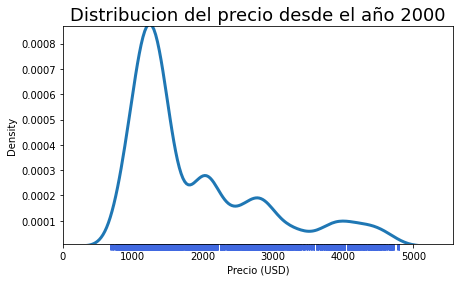

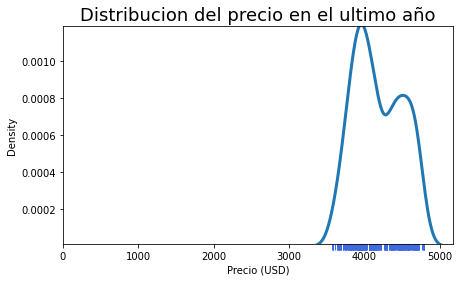

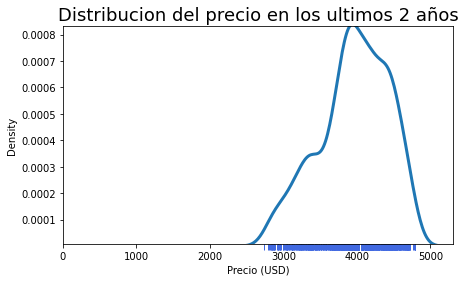

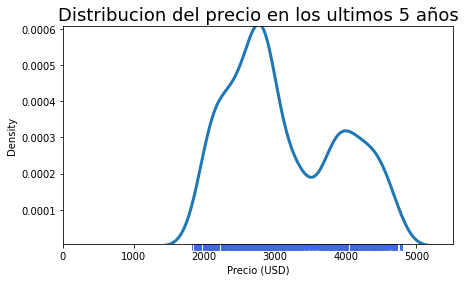

In [ ]:
# Distribución KDE del precio de cierre

fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=syp500, x='Close', linewidth=3, ax=ax)
r = sns.rugplot(data=syp500, x='Close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('Distribucion del precio desde el año 2000', fontsize=18)
p.set_xlabel('Precio (USD)');

fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=syp500_1y, x='Close', linewidth=3, ax=ax)
r = sns.rugplot(data=syp500_1y, x='Close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('Distribucion del precio en el ultimo año', fontsize=18)
p.set_xlabel('Precio (USD)');

fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=syp500_2y, x='Close', linewidth=3, ax=ax)
r = sns.rugplot(data=syp500_2y, x='Close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('Distribucion del precio en los ultimos 2 años', fontsize=18)
p.set_xlabel('Precio (USD)');

fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=syp500_5y, x='Close', linewidth=3, ax=ax)
r = sns.rugplot(data=syp500_5y, x='Close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('Distribucion del precio en los ultimos 5 años', fontsize=18)
p.set_xlabel('Precio (USD)');

print("Obseramos que el precio en los ultimos años ronda entre los 4000 y 4500 usd")

In [ ]:
# Se localizan los datos correspondientes para cada año

years = list(syp500.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = syp500.loc[syp500.index.year == year, 'Open'][0]
    year_close = syp500.loc[syp500.index.year == year, 'Close'][-1]
    year_low   = syp500.loc[syp500.index.year == year, 'Low'].min()
    year_high  = syp500.loc[syp500.index.year == year, 'High'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['Open', 'Close', 'Low', 'High'], axis=1)

# Se calcula el % de cambio entre el open y el close del año
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['Close'] - df_plot['Open']) / df_plot['Open']
df_plot.head(3)

,Open,Close,Low,High,year_change
2000,1469.250000,1320.280029,1254.069946,1552.869995,-10.139185
2001,1320.280029,1148.079956,944.750000,1383.369995,-13.042693
2002,1148.079956,879.820007,768.630005,1176.969971,-23.365964


In [ ]:
# Se crea una lista de dicts con las anotaciones de % de cambio para el gráfico
# ==============================================================================
annotations_list = []
max_high = df_plot['High'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['High'].values[0]/max_high + 0.05
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo con Plotly
# ==============================================================================
candlestick2 = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.Open,
                  close = df_plot.Close,
                  low   = df_plot.Low,
                  high  = df_plot.High
              )

fig = go.Figure(candlestick2)
fig.show()

In [ ]:
# Se localizan los datos correspondientes para cada mes, usaremos los ultimos 5 años de la muestra
# ==============================================================================
years = list(syp500_5y.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):
        
        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (syp500_5y.index >= start_date) & (syp500_5y.index < end_date)
        
        if not syp500_5y.loc[mask, :].empty:
                        
            month_open  = syp500_5y.loc[mask, 'Open'][0]
            month_close = syp500_5y.loc[mask, 'Close'][-1]
            month_low   = syp500_5y.loc[mask, 'Low'].min()
            month_high  = syp500_5y.loc[mask, 'High'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['Open', 'Close', 'Low', 'High'], axis=1)

In [ ]:
# Gráfico boxplot para estacionalidad mensual
df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='Close')

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['Close'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='Close', markers=True)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>SYP500 Precio por mes (5 años)</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)


fig.show()

In [ ]:
# Gráfico boxplot para estacionalidad cada dia de la semana en los ultimos 5 años
# ==============================================================================

syp500_5y['dia_mes'] = pd.Series(syp500_5y.index).dt.day.values

# fig 1 boxplot de los días del mes
fig1 = px.box(syp500_5y.sort_values('dia_mes'), x='dia_mes', y='Close')

# fig 2 line con datos de la mediana de los días del mes
df_median = pd.DataFrame(syp500_5y.groupby('dia_mes')['Close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='Close', markers=True)

fig = go.Figure(data=fig1.data + fig2.data)
fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>SYP500 Precio por día del mes (5 años)</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

<ipython-input-12-52b9c096e638>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Se localizan los datos correspondientes para cada mes, usaremos los ultimos 2 años de la muestra

years = list(syp500_2y.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):
        
        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (syp500_2y.index >= start_date) & (syp500_2y.index < end_date)
        
        if not syp500_2y.loc[mask, :].empty:
                        
            month_open  = syp500_2y.loc[mask, 'Open'][0]
            month_close = syp500_2y.loc[mask, 'Close'][-1]
            month_low   = syp500_2y.loc[mask, 'Low'].min()
            month_high  = syp500_2y.loc[mask, 'High'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['Open', 'Close', 'Low', 'High'], axis=1)

# Gráfico boxplot para estacionalidad mensual
df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='Close')

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['Close'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='Close', markers=True)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>SYP500 Precio por mes (2 años)</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [ ]:
# Gráfico boxplot para estacionalidad cada dia de la semana en los ultimos 2 años
# ==============================================================================

syp500_2y['dia_mes'] = pd.Series(syp500_2y.index).dt.day.values

# fig 1 boxplot de los días del mes
fig1 = px.box(syp500_2y.sort_values('dia_mes'), x='dia_mes', y='Close')

# fig 2 line con datos de la mediana de los días del mes
df_median = pd.DataFrame(syp500_2y.groupby('dia_mes')['Close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='Close', markers=True)

fig = go.Figure(data=fig1.data + fig2.data)
fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>SYP500 Precio por día del mes (2 años)</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

<ipython-input-14-cd851dcceccd>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Gráfico boxplot para estacionalidad semanal para los ultimos 2 años
# ==============================================================================
syp500_2y['dia_semana'] = syp500_2y.index.day_of_week + 1

# fig 1 boxplot de los días de la semana
fig1 = px.box(syp500_2y.sort_values('dia_semana'), x='dia_semana', y='Close')

# fig 2 line con datos de la mediana los días de la semana
df_median = pd.DataFrame(syp500_2y.groupby('dia_semana')['Close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_semana', y='Close', markers=True)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>SYP500 Precio por día de la semana (2 años)</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

<ipython-input-15-fcaec1358acc>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Podemos observar una estacionalidad en el precio entre el inicio y final del año.

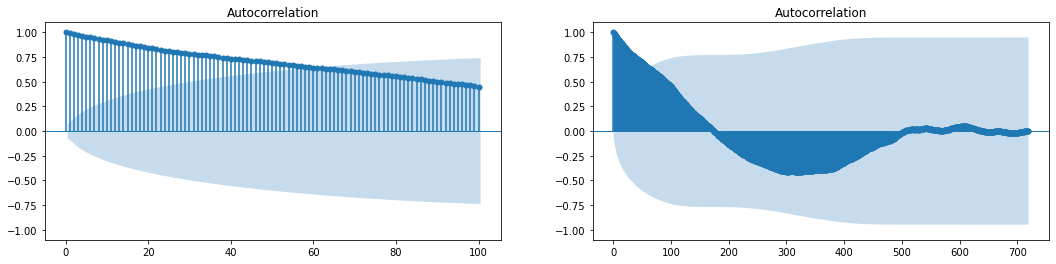

In [ ]:
# Gráfico autocorrelación para los ultimos 2 años
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(syp500_2y.Close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(syp500_2y.Close, ax=axes[1], linewidth = 1, lags=719)
axes[1].set_ylim(-1.1, 1.1)
plt.show()


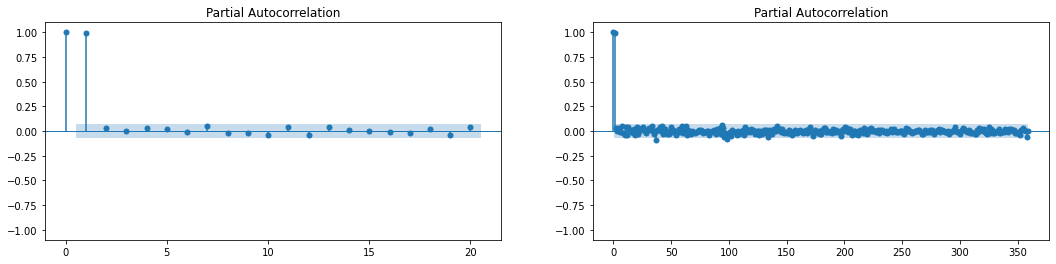

In [ ]:
# Gráfico autocorrelación parcial para los ultimos 2 años
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(syp500_2y.Close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(syp500_2y.Close, ax=axes[1], lags=359, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

Los gráficos de autocorrelación indican que el lag 1 es el único que está correlacionado con el lag 0. Los siguientes lags no superan el umbral de significancia.